# Ch_06_학습 관련 기술들

6장에서는 신경망의 학습 효율을 높이기 위한 방법들을 설명하고자 한다.

설명할 내용들은 다음과 같다.

최적의 가중치 매개변수를 찾기 위한 최적화 방법.

초기 가중치 매개변수 설정에 관한 방법.

오버피팅 조정하는 방법.

배치 정규화.

6.1 매개변수 갱신

신경망 학습의 원리는 손실함수라는 지표를 정의한 다음에 손실함수 값을 가장 적게 하는 최적의 가중치 매개변수를 구하는 것이었다.

이처럼 어떤 목적함수의 최솟값을 찾는 문제를 수학에서는 최적화(Optimization)라고 한다.

하지만, 실제 feasible set의 영역이 매우 넓고, 변수 또한 많기 때문에 쉽게 계산 되지 않는다.

앞 단원에서 매개변수에 대한 손실함수의 기울기인 Gradient를 이용한 SGD(Stochastic Gradient Descent,확률적 경사 하강법)을 공부했다.

SGD는 처음 최적화를 풀 때 가장 자연스러운 방법이지만, 한계가 존재한다. 장단점을 살펴 본 후 보완할 수 있는 방법을 살펴보자.

6.1.1 모험가 이야기

어떤 모험가가 앞을 볼 수 없는 상태에서 현재의 위치로부터 가장 낮은 곳으로 가기 위해선 어떻게 해야할까?

지금 있는 곳에서 가장 땅의 기울기가 크게 기울어지는 곳으로 가면 될 것 같다.

6.1.2 SGD

SGD의 기본 원리를 복기 해보자.

현재의 가중치 행렬을 $\mathbf{W}$라 하면, 학습률 $\eta$에 대해 새로운 가중치를 다음과 같이 업데이트 한다.

[식 6.1]$~~~~\mathbf{W} \leftarrow \mathbf{W} - \eta \frac{ \partial{L}}{\partial{W}} $

간단한 SGD를 구현해보자.

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads): #성분 별이 아닌 행렬 통째로 업데이트 함.
        for key in params.keys():
            params[key] -= self.lr * grads[key]

코드를 살펴보면, SGD라는 클래스 속의 update라는 Method는 params, grads라는 것을 인수로 받는데, params['W1']과 같이 행렬형태로 저장이 되기 때문에 업데이트가 행렬 통째로 됨을 짐작 할 수 있다.

이 SGD 클래스를 이용하여 앞에서의 신경망에서 매개변수 갱신 부분에 사용하면 된다.

6.1.3 SGD의 단점

개념 자체가 자연스럽고, 계산도 그리 복잡하지 않음에도 불구하고 SGD가 널리 쓰이지 않는 이유가 있다.

다음과 같은 식을 생각해보자.

[식 6.2]
![](data/images/e%206.2.png)
위의 식을 그래프로 그리면 다음과 같다.
![](data/images/fig%206-1.png)
이 때 [식 6.2]의 각 점에서의 Gradient를 살펴보면,
![](data/images/fig%206-2.png)
즉, y축 방향은 크게 감소하는데 x축 방향은 크게 바뀌지 않는다. 그리고 Global minimum 값은 (0,0)에서 나타나는게 자명하지만, Gradient는 모두 (0,0)을 가리키진 않는다. 이런 함수에 대해 SGD를 한번 적용해보자.

초기값을 (-7,2)로 했을 때 SGD 적용 결과는
![](data/images/fig%206-3.png)
즉, global minimum인 (0,0)으로 가긴 하지만, 지그재그 형태로 매우 많은 반복횟수를 거쳐 감을 알 수 있다.

이런 지그재그 현상이 일어나는 근본적인 원인은 각 점에서의 Gradient의 방향이 Global Minimum의 방향이 아니기 때문에 일어난다.

이런 현상을 개선하기 위해 모멘텀(Momentum), AdaGard, Adam 3가지 방법을 소개한다.

6.1.4 모멘텀

모멘텀은 물리에서 '운동량'과 관련이 있는 개념이다. 그 이전의 움직임을 다음 움직임에 반영하겠다는 의미로 모멘텀이란 단어가 쓰인것 같다.

모멘텀 기법은 다음과 같이 업데이트를 한다.

$\mathbf{v} \leftarrow \alpha\mathbf{v} - \eta\frac{\partial{L}}{\partial{W}} \quad$ :속도에 해당하는 개념

$\mathbf{W}\leftarrow\mathbf{W} + \mathbf{v}$ 

일반적인 SGD에서는 $k$번째 스텝에서의 descent direction을 $k$번째 weight에 의한 L의 gradient direction으로 결정했다면,

모멘텀 기법은 $k$번째 스텝에서 descent direction을 $k-1$번째의 속도에 관련된 부분과 $k$번째의 gradient 방향을 모두 고려하겠다는 것이다.

그림을 그려보면 다음과 같다.

![](data/images1/momentum.png)
이 때 최초의 속도($\mathbf{v}_{0}$)는 gradient와 같은 값으로 설정한다.

모멘텀 기법을 구현해보자.

In [1]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momnetum = momentum
        self.v = None
    
    def update(self, params, grads): 
        if self.v is None: #초기 속도를 설정하는데.... 뭐지
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in paras.key():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

모멘텀 기법을 사용하여 [식 6-2]의 최솟값을 구해보면,
![](data/images/fig%206-5.png)
단순한 SGD를 풀었을 때보다 조금 더 부드럽게 접근을 한다.

6.1.5 AdaGrad

SGD에서의 Learning Rate를 무엇으로 할것인지 또한 중요한 문제가 된다.

학습률을 정하는 방법은 여러가지가 있는데, 그 중 학습을 진행하면서 학습률을 점점 줄여가는 방법인 '학습률 감소'라는 방법이 있다.

이에 관련된 방법이 바로 AdaGrad이다.

AdaGrad는 각각의 매개변수에 적응하여(Adaptive) 학습률을 결정한다.

때문에 Adaptive Gradient 를 줄여 AdaGrad라고 이름을 붙인듯 하다.

AdaGrad의 갱신 방법을 수식으로 나타내면 다음과 같다.

[식 6.5]
$\mathbf{h} \leftarrow \mathbf{h} + \frac{\partial{L}}{\partial{W}} \odot \frac{\partial{L}}{\partial{W}}$

[식 6.6]
$\mathbf{W} \leftarrow \mathbf{W} - \eta \frac{1}{\sqrt{\mathbf{h}}} \odot \frac{\partial{L}}{\partial{\mathbf{W}}}$

이 식을 설명하기 위해 간단한 최적화 문제를 생각해보자. 

$f:\mathbb{R}^{n} \rightarrow \mathbb{R}$인 함수의 최솟값을 구한다고 생각해보자.

이 경우의 SGD의 업데이트 방식을 살펴보면, 

$\mathbf{x}_{k+1} = \mathbf{x}_{k} - \eta \cdot \nabla f(\mathbf{x}_{k})$

이를 벡터로 표현하면,

$\begin{pmatrix} {x_{1}}^{(k+1)} \\ \vdots \\ {x_{n}}^{(k+1)} \end{pmatrix} = \begin{pmatrix} {x_{1}}^{(k)} \\ \vdots \\ {x_{n}}^{(k)} \end{pmatrix}- \eta \begin{pmatrix} (\nabla f(\mathbf{x}_{k}))_{1} \\ \vdots \\ (\nabla f(\mathbf{x}_{k}))_{n} \end{pmatrix}$

이 때, $(\nabla f(\mathbf{x}_{k}))_{i} = g_{k,i}$ 라고 쓰면, 업데이트의 성분별 표현은 

${x_{i}}^{(k+1)} = {x_{i}}^{(k)} - \eta \cdot g_{k,i}$로 나타낼 수 있다.

그렇다면 AdaGrad의 성분별 업데이트의 식은 다음과 같다.

${x_{i}}^{(k+1)} = {x_{i}}^{(k)} - \frac{\eta}{\sqrt{(\sum_{t=1}^k {g^{2}_{t,i}})+\epsilon}} \cdot g_{k,i}$

(이 때 $\epsilon$은 분모가 0이 되는 경우를 방지하기 위한 임의의 양수라 생각. 보통 $10^{-8}$을 택한다. 여기서는 우선 0이라고 생각하자.)

(즉 k번째 까지의 ${\nabla f(x_{t})}^{2}$을 다 더한 값이 분모로 들어가므로 매 순간 learning rate 값은 바뀌고, 그 분모의 값이 점점 증가 하므로 learning rate의 값은 점점 감소하게 된다.)

이를 다시 벡터로 나타내면,

$\begin{pmatrix} {x_{1}}^{(k+1)} \\ \vdots \\ {x_{n}}^{(k+1)} \end{pmatrix} = \begin{pmatrix} {x_{1}}^{(k)} \\ \vdots \\ {x_{n}}^{(k)} \end{pmatrix}- \begin{pmatrix} \frac{\eta}{\sqrt{\sum_{t=1}^k {g^{2}}_{t,1}}} \cdot g_{k,1} \\ \vdots \\ \frac{\eta}{\sqrt{\sum_{t=1}^k {g^{2}_{t,n}}}} \cdot g_{k,n} \end{pmatrix}$

이를 다시 벡터간의 원소 곱을 나타내는 $\odot$ 이 기호를 이용하면,

$\begin{pmatrix} {x_{1}}^{(k+1)} \\ \vdots \\ {x_{n}}^{(k+1)} \end{pmatrix} = \begin{pmatrix} {x_{1}}^{(k)} \\ \vdots \\ {x_{n}}^{(k)} \end{pmatrix} - \begin{pmatrix} \frac{\eta}{\sqrt{\sum_{t=1}^k {g^{2}_{t,1}}}} \\ \vdots \\ \frac{\eta}{\sqrt{\sum_{t=1}^k {g^{2}_{t,n}}}} \end{pmatrix} \odot \begin{pmatrix} g_{k,1} \\ \vdots \\ g_{k,n} \end{pmatrix}$

이제 $\begin{pmatrix} \sum_{t=1}^k {g^{2}_{t,1}} \\ \vdots \\ \sum_{t=1}^k {g^{2}_{t,n}} \end{pmatrix} = \mathbf{G}_{k}$라고 하고 다시 쓰면,

$\mathbf{x}_{k+1} = \mathbf{x}_{k} - \frac{\eta}{\sqrt{\mathbf{G}_{k}}} \odot \nabla f(\mathbf{x}_{k}) $

여기서 $\mathbf{G}_{k} = \mathbf{h}$ 라고 보면, 식 6.5와 식 6.6이 설명이 된다.

AdaGrad의 장점은 매 단계마다 스스로 학습률을 조정해준다.

하지만 단점으로는 학습률의 분모 부분에는 계속해서 양수가 더해지므로 숫자가 커진다. 따라서 학습률은 단계가 지나면 지날수록 작아지기 때문에, 계속해서 학습을 하는 경우에는 학습률이 매우 작아져 더 이상 학습이 안될 수도 있다.

이 단점의 보완으로 RMSProp이라는 방법이 있는데, 이 방법은 나중에 SGD를 정리할 때 다시 공부해보자.

이제 AdaGrad를구현해보자.

In [4]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h =None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key])+1e-7)
            

이 AdaGrad 방법을 이용하여 [식 6.2]의 최적화 문제를 풀어보면 경로는 다음과 같다.

![](data/images/fig%206-6.png)
처음에 y축 방향으로의 감소률이 크므로 단계가 지날 때마다 y축 방향으로의 감소율이 조정이 되 지그재그같은 움직임이 사라진다.

6.1.6 Adam

모멘텀은 각 점에서의 Gradient에다 그 이전의 움직임까지 고려해서 다음 방향을 결정하는 방법이고,

AdaGrad는 학습이 진행 됨에 따라 학습률이 조절되는 방법이었다.

Adam은 간단히 말하면 모멘텀과 AdaGrad의 방법(정확히는 RMSprop)을 융합한 개념이다.

간단히 RMSprop에 대해 살펴보자.

AdaGrad의 핵심 개념은 학습률의 분모 부분에 그 이전까지의 Gradient의 제곱합을 더한 값의 루트 값이 있었다.

RMSprop의 기본 개념은 단계가 지남에 따라 초기의 gradient값의 영향력은 줄이고, 전 단계의 gradient의 영향력을 더 반영하겠다는 것이다.

즉, $\sum_{t=1}^k {g^{2}_{t,i}}$ 대신에, $\ 0.9 \cdot (\sum_{t=1}^{k-1} {g^{2}_{t,i}}) + 0.1 \cdot {g^{2}}_{k,i}$로 사용하겠다는 뜻이다.

어쨋든 ${g^{2}}_{1,i}\ ,{g^{2}}_{2,i}\ ,...,\ {g^{2}}_{k-1,i}$의 평균으로 나타나지므로 다시 적으면,

$E[{g^{2}}_{i}]_{k} = 0.9 \cdot E[{g^{2}}_{i}]_{k-1} + 0.1 \cdot {g^{2}}_{k,i}$

이 개념을 이용하여 RMSprop의 성분별 업데이트 형식을 살펴보면,

${x_{i}}^{(k+1)} = {x_{i}}^{(k)} - \frac{\eta}{\sqrt{E[{g^{2}}_{i}]_{k}+\epsilon}} \cdot g_{k,i}$

이제 Adam에 대해서 생각해보자. 

먼저 AdaGrad와, RMSprop의 알고리즘 업데이트를 다시 살펴보면,

AdaGrad : ${x_{i}}^{(k+1)} = {x_{i}}^{(k)} - \frac{\eta}{\sqrt{(\sum_{t=1}^k {g^{2}_{t,i}})+\epsilon}} \cdot g_{k,i}$

RMSprop : ${x_{i}}^{(k+1)} = {x_{i}}^{(k)} - \frac{\eta}{\sqrt{E[{g^{2}}_{i}]_{k}+\epsilon}} \cdot g_{k,i}$

Adam은 이미 언급했듯이 모멘텀과 AdaGrad를 융합한 개념이다.

이전의 Gradient의 지수평균을 계속 저장한 것을 모멘텀으로 사용하면서, RMSprop에서의 기울기의 제곱 부분을 지수평균으로 저장하여 학습률도 함께 업데이트하는 방식이다.

momentum에 해당하는 부분을 $m_{k}=({m^{(k)}}_{1}, ... ,{m^{(k)}_{n}})$, 학습률에 해당하는 부분을 $ v_{k}=({v^{(k)}}_{1}, ... ,{v^{(k)}_{n}})$라 하자.

이 때 각 $m_{k}$와 $v_{k}$는 다음과 같이 업데이트 된다.

$m_{k}= \beta_{1} m_{k-1} + (1 - \beta_{1})\nabla f(x_{k}) \quad $: momentum에 해당하는 부분 

$v_{k}= \beta_{2} v_{k-1} + (1 - \beta_{2})(\nabla f(x_{k}))^{2} \quad $ : 학습률에 해당하는 부분

(이 때 $\beta_{1}, \beta_{2} $는 사람이 정해주는 Hyperparameter(초모수)에 해당하는 수, 경험적으로  $\beta_{1}=0.9, \beta_{2}=0.999$ )

그런데 0-step에서 $m_{0} = v_{0} = \mathbf{0}$ 이렇게 초기화가 될텐데, 그렇게 되면 처음 몇 step은 $\mathbf{0}$에 굉장히 편향되어있게 된다.

이 편향된 부분을 조정하기 위해 간단한 과정을 거쳐 다음의 값을 도출해낸다.

$ \hat{m}_{k} = \frac{m_{k}}{1 - {\beta_1}^k} $

$ \hat{v}_{k} = \frac{v_{k}}{1 - {\beta_2}^k} $

이 값을 이용하여 업데이트를 진행했을 때 성분별 업데이트 형식은 다음과 같다.

${x_{i}}^{(k+1)} = {x_{i}}^{(k)} - \frac{\eta}{\sqrt{{\hat{v}^{(k)}}_{i}}+\epsilon} \cdot {\hat{m}}^{(k)}_{i}$

벡터로 표시하면,

$ \mathbf{x_{k+1}} = \mathbf{x_{k}} - \frac{\eta}{\sqrt{\mathbf{\hat{v}_{k}}}+\epsilon} \odot \mathbf{\hat{m}_{k}}$


6.1.7 어느 갱신 방법을 이용할 것인가?

[그림 6-8] SGD, 모멘텀, AdaGrad, Adam의 경로 비교
![](data/images/fig%206-8.png)
때에 따라, 문제에 따라 최적의 효과를 나타내는 방법을 사용하면 되겠다.

6.1.8 MNIST 데이터셋으로 갱신 방법 비교

===========iteration:0===========
SGD:2.37890445825
Momentum:2.38908935464
AdaGrad:2.65607133723
Adam:2.19959963637
===========iteration:100===========
SGD:1.47149902577
Momentum:0.437338638339
AdaGrad:0.176198872298
Adam:0.341572967014
===========iteration:200===========
SGD:0.752603553578
Momentum:0.208263539964
AdaGrad:0.0756324229167
Adam:0.158374410294
===========iteration:300===========
SGD:0.472858093384
Momentum:0.176365472052
AdaGrad:0.0814134341203
Adam:0.138417543582
===========iteration:400===========
SGD:0.338376567123
Momentum:0.123288119616
AdaGrad:0.0274711736393
Adam:0.0609568629233
===========iteration:500===========
SGD:0.408933827213
Momentum:0.231819414908
AdaGrad:0.116294956469
Adam:0.237288496255
===========iteration:600===========
SGD:0.37053409209
Momentum:0.176200848147
AdaGrad:0.0739998947011
Adam:0.120858876438
===========iteration:700===========
SGD:0.473012903679
Momentum:0.22971921435
AdaGrad:0.149270111055
Adam:0.209397348905
===========iteration:800====

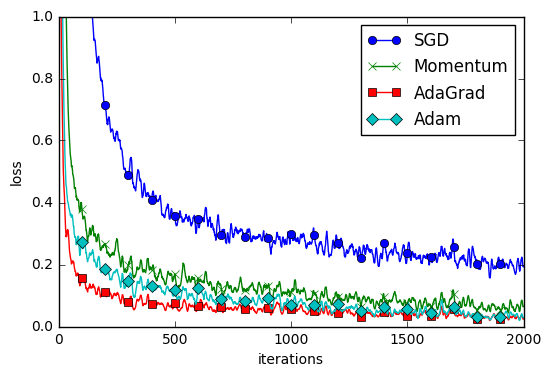

In [2]:
# MNIST 데이터셋으로 갱신 방법 비교
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

6.2 가중치의 초깃값

가중치의 초깃값을 무엇으로 설정하느냐에 따라 학습속도나 정확도가 달라진다. 어떻게 가중치 초깃값을 결정할지 살펴보자.

6.2.1 초깃값을 0으로 하면?

결론부터 말하면 이는 좋은 방법이 아니다. 0이라서 안좋다기 보다는, 가중치 값을 모두 균일하게 설정하는 것이 좋지 않다. 그 이유는 오차역전파법을 생각해보면 된다. 오차역전파법은 곱셈 노드를 기준으로 순전파와 서로 반대되는 값을 역전파에서 전파를 했는데, 만약 가중치 값이 동일한 값을 선택하게 되면 순전파 방향에서 똑같은 값이 곱해지므로 역전파때도 같은 양이 전파되기 때문에 업데이트가 되지 않는다.

6.2.2 은닉층의 활성화 값 분포

가중치의 초깃값에 따라 은닉층의 활성화 값(활성화 함수를 통과한 값)들이 어떤 분포를 나타내는지 살펴보자.

활성화 함수로 시그모이드 함수를 사용.

In [6]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    #w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

현재 상황은 5개의 층이 있고, 각층의 뉴런(노드)는 100개씩 있다. 이때 입력데이터 1000개를 정규분포로 무작위로 생성하여 5층 신경망에 흘린다. 이때 각 활성화함수로는 시그모이드 함수를 사용했고, 각 층의 활성화 결과를 activations 변수에 저장한다.

이때 처음에는 표준편차가 1인 정규분포로 데이터를 생성했는데, 이 표준편차가 바뀜에 따라 신경망을 지난 활성화 값이 어떻게 바뀌는지를 확인할 것이다.

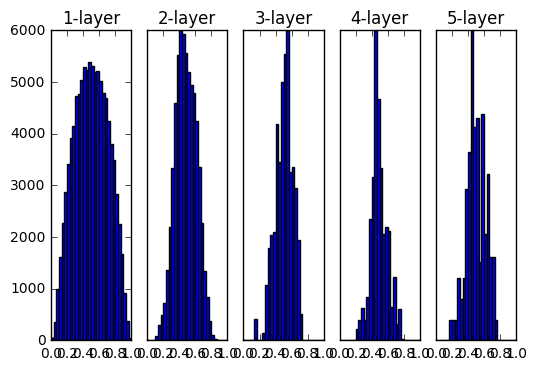

In [7]:
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

그래프를 보면, x축은 활성화 함수의 값을 나타내고, y축은 그 값을 나타내는 빈도이다. 5개의 층 모두에서 0과 1의 빈도가 가장 많이 나타났다.

이 때, 활성화 함수로 시그모이드 함수를 사용했는데, 시그모이드 함수는 x가 0 또는 1에 가까울 수록 기울기 값이 0에 가까워진다.

때문에, 위의 분포 처럼 0과 1에 데이터가 많이 분포 되어있다면, 역전파를 통해 기울기 업데이트를 할 때 기울기가 잘 업데이트 되지 않을 확률이 크다. 

이런 문제를 기울기 소실(Gradient Vanishing)이라고 한다.

이번엔 표준편차를 0.01로 했을 때의 분포를 살펴보자.

[그림 6-11] 표준 편차가 0.01 일 때의 분포
![](data/images/fig%206-11.png)
이번에는 0.5 근처에 많은 분포를 나타내는데, 0과 1로 치우치지 않았으니 기울기 소실 문제는 일어나지 않는다.

하지만, 활성화 값들이 0.5 근방으로 치우쳤다는 것은 거의 모든 뉴런이 같은 값을 출력하고 있다고 볼 수 있다. 이것은 여러개의 뉴런을 두는 것에 의미가 없어진다. 이런 문제를 '표현력 제한 문제'라고 한다.

이제 한 값의 분포가 크게 나타나는 것이 아닌, 고루 분포가 되어야 좋을 것 같다.

그런 결과를 나타내는 초깃 값이 바로 Xavier (싸비에르) 초깃값이다.

[그림 6-12] Xavier 초깃값: 초깃값의 표준편차를 앞 층의 노드의 갯수(n)에 대해 $\frac{1}{\sqrt{n}}$으로 한다.
![](data/images/fig%206-12.png)

[그림 6-13] Xavier 초깃값을 이용할 때의 각층의 활성화 분포
![](data/images/fig%206-13.png)

6.2.3 ReLu를 사용할 때의 가중치 초깃값

Xavier 초깃값은 활성화 함수가 선형(시그모이드도 좌우 대칭이라 선형이라 볼 수 있음)일 때 적절하였다. 

ReLu에 적합한 초깃값을 찾아보자.

He 초깃값이라고 있는데, 앞 층의 노드의 갯수($n$)에 대해서 표준 편차가 $\sqrt{\frac{2}{n}}$인 분포를 띄게끔 한다.

[그림 6-14] 활성화 함수로 ReLu 함수를 사용한 경우 가중치 초깃값에 따른 분포 변화
![](data/images/fig%206-14.png)

표준편차가 0.01인 경우에는 활성화 함수 값이 매우 작아서 거의 학습이 이루어지지 않게 되고,

Xavier 초깃값을 사용하는 경우 층이 지날수록 치우침이 생기면서 0의 값이 많아 지므로 기울기 소실 문제가 생길 수 있다.

정리를 하자면, 활성화 함수로 시그모이드나 tanh 함수 등(S자 모양의 곡선)을 사용할 때에는 초깃값으로 Xavier 초깃값을 사용하고,

ReLu인 경우에는 He 초깃값을 사용한다.

6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교.

실제로 데이터를 이용하여 가중치 초깃값이 손실함수를 감소시키는데 얼마나 영향을 미치는지 살펴보자.

[그림 6-15] MNIST 데이터셋으로 살펴본 가중치 초깃값에 따른 비교
![](data/images/fig%206-15.png)

===========iteration:0===========
std=0.01:2.30245889829
Xavier:2.32334732757
He:2.40696058802
===========iteration:100===========
std=0.01:2.30332860822
Xavier:2.24066336535
He:1.49142639842
===========iteration:200===========
std=0.01:2.30139759793
Xavier:2.1379341757
He:0.793840964164
===========iteration:300===========
std=0.01:2.30216636888
Xavier:1.80442696405
He:0.517236640368
===========iteration:400===========
std=0.01:2.3004835296
Xavier:1.30117482673
He:0.41474823035
===========iteration:500===========
std=0.01:2.29798225012
Xavier:0.929029557294
He:0.466238095734
===========iteration:600===========
std=0.01:2.29663297139
Xavier:0.670944886718
He:0.332842070831
===========iteration:700===========
std=0.01:2.30477466139
Xavier:0.771698000484
He:0.570405455688
===========iteration:800===========
std=0.01:2.30274426349
Xavier:0.421003511221
He:0.211903961216
===========iteration:900===========
std=0.01:2.30123715337
Xavier:0.474201374815
He:0.33468272574
===========iteration:10

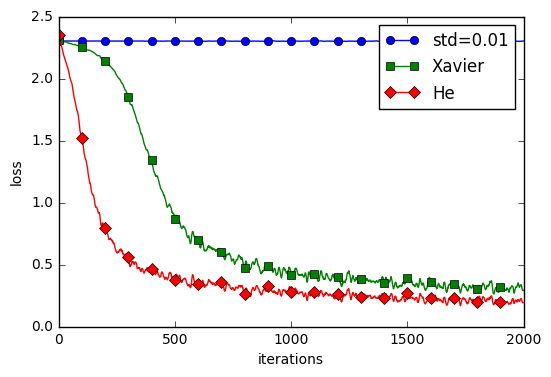

In [4]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()


그림에서 알 수 있듯이, 표준편차가 0.01인 경우에는 거의 학습이 이루어 지지 않는다. 그리고 활성화 함수로 ReLU함수를 사용했기 때문에 Xavier보다는 He 초깃값이 더 적은 반복횟수로 수렴하는 것을 볼 수 있다.

이로 써 초깃값 설정이 학습 속도에도 영향을 크게 미친다는 것을 알 수 있다.

6.3 배치 정규화

앞 절에서는 가중치의 초깃값을 어떤 분포로 해야 활성화 값들이 적절하게 분포하는지 살펴보았다. 이번에는 각 층이 활성화를 적당히 퍼뜨리도록 하는 방법을 생각해보자. 이와 관련된 방법을 배치 정규화(Batch Normalizaion)이라고 한다.

6.3.1 배치 정규화 알고리즘

배치정규화의 장점은 다음과 같다.

1. 학습 속도 개선

2. 초깃값에대한 의존성이 낮음.

3. 오버피팅을 억제.

[그림 6-16] 배치 정규화를 사용한 신경망의 예
![](data/images/fig%206-16.png)
각 배치 정규화 속에서는 데이터들을 모두 정규화 시킨다. 

그 과정은 고교시절 배운 정규화와 같다.

[식 6-7] 배치 정규화 과정
![](data/images/e%206.7.png)
이 정규화 과정은 미니 배치 $\mathbf{B}=\{ x_1, x_2, ... , x_m \}$ 에 대해 시행하며, 분산이 0이 되는 경우를 피하기 위해 $\epsilon$을 더해준다.

그리고 정규화 계층 마다 정규화된 데이터에 확대 및 이동 변환을 수행한다. 

[식 6.8] 정규화된 데이터를 확대 및 이동
![](data/images/e%206.8.png)
이를 계산 그래프로 그려보면,

[그림 6-17] 배치 정규화의 계산 그래프
![](data/images/fig%206-17.png)
(아직 배치 정규화의 정확한 그림이 그려지지 않음..)

6.3.2 배치 정규화의 효과

배치 정규화를 하였을 때와 하지 않았을 때의 학습속도 등을 비교해보자. 그리고 가중치 초깃값의 표준편차도 바꿔가며 살펴보자.

============== 1/16 ==============


C:\Users\yalhl_000\DeepLearning\common\functions.py:56: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size


epoch:0 | 0.087 - 0.111


C:\Users\yalhl_000\DeepLearning\common\layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)
C:\Users\yalhl_000\DeepLearning\common\multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C:\Users\yalhl_000\DeepLearning\common\multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.101
epoch:2 | 0.097 - 0.117
epoch:3 | 0.097 - 0.134
epoch:4 | 0.097 - 0.156
epoch:5 | 0.097 - 0.183
epoch:6 | 0.097 - 0.205
epoch:7 | 0.097 - 0.215
epoch:8 | 0.097 - 0.232
epoch:9 | 0.097 - 0.246
epoch:10 | 0.097 - 0.27
epoch:11 | 0.097 - 0.289
epoch:12 | 0.097 - 0.302
epoch:13 | 0.097 - 0.312
epoch:14 | 0.097 - 0.333
epoch:15 | 0.097 - 0.348
epoch:16 | 0.097 - 0.372
epoch:17 | 0.097 - 0.382
epoch:18 | 0.097 - 0.401
epoch:19 | 0.097 - 0.405
============== 2/16 ==============
epoch:0 | 0.105 - 0.063


C:\Users\yalhl_000\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


epoch:1 | 0.097 - 0.07
epoch:2 | 0.097 - 0.088
epoch:3 | 0.097 - 0.123
epoch:4 | 0.097 - 0.159
epoch:5 | 0.097 - 0.182
epoch:6 | 0.097 - 0.199
epoch:7 | 0.097 - 0.222
epoch:8 | 0.097 - 0.246
epoch:9 | 0.097 - 0.267
epoch:10 | 0.097 - 0.29
epoch:11 | 0.097 - 0.326
epoch:12 | 0.097 - 0.346
epoch:13 | 0.097 - 0.36
epoch:14 | 0.097 - 0.381
epoch:15 | 0.097 - 0.398
epoch:16 | 0.097 - 0.406
epoch:17 | 0.097 - 0.424
epoch:18 | 0.097 - 0.443
epoch:19 | 0.097 - 0.458
============== 3/16 ==============
epoch:0 | 0.096 - 0.072
epoch:1 | 0.28 - 0.093
epoch:2 | 0.442 - 0.142
epoch:3 | 0.518 - 0.185
epoch:4 | 0.604 - 0.236
epoch:5 | 0.647 - 0.283
epoch:6 | 0.648 - 0.32
epoch:7 | 0.726 - 0.368
epoch:8 | 0.75 - 0.406
epoch:9 | 0.794 - 0.439
epoch:10 | 0.826 - 0.472
epoch:11 | 0.85 - 0.492
epoch:12 | 0.867 - 0.532
epoch:13 | 0.883 - 0.551
epoch:14 | 0.889 - 0.568
epoch:15 | 0.903 - 0.585
epoch:16 | 0.916 - 0.599
epoch:17 | 0.923 - 0.625
epoch:18 | 0.93 - 0.64
epoch:19 | 0.936 - 0.652
============== 4/1

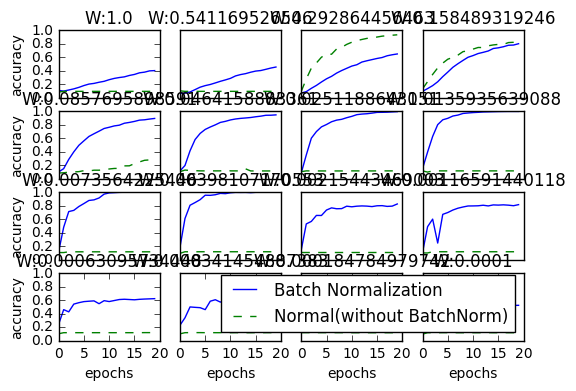

In [5]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()


조금 더 깔끔한 그림으로 보면,

[그림 6-19] 가중치 초깃값을 변화시켜가며 정규배치화를 하였을 때와 하지 않았을 때의 정확도
![](data/images/fig%206-19.png)
거의 모든 경우에서 배치정규화를 하였을 때가 그렇지 않을 때보다 정확도가 더 높게 나왔다. 

때문에 가중치 초깃값에 영향을 덜 받으면서 좋은 결과를 내니 살펴볼 만 하다.

6.4 올바른 학습을 위해

올바른 학습을 위해 오버피팅을 잘 조절해야하는데, 거기에 관련된 걸 살펴보자.

6.4.1 오버피팅

오버피팅은 주로 (1) 매개변수가 많고 표현력이 높은 모델, (2) 훈련 데이터가 적은 경우 에 자주 일어난다.

일부러 오버피팅이 생기도록 훈련 데이터의 수를 줄이고, 기존 5층 네크워크에서 7층으로 바꾸어보자.

epoch:0, train acc:0.113333333333, test acc:0.0978
epoch:1, train acc:0.113333333333, test acc:0.1032
epoch:2, train acc:0.126666666667, test acc:0.1093
epoch:3, train acc:0.136666666667, test acc:0.1144
epoch:4, train acc:0.14, test acc:0.1227
epoch:5, train acc:0.17, test acc:0.1476
epoch:6, train acc:0.22, test acc:0.1741
epoch:7, train acc:0.246666666667, test acc:0.1899
epoch:8, train acc:0.266666666667, test acc:0.1955
epoch:9, train acc:0.286666666667, test acc:0.223
epoch:10, train acc:0.336666666667, test acc:0.2516
epoch:11, train acc:0.35, test acc:0.2696
epoch:12, train acc:0.376666666667, test acc:0.2808
epoch:13, train acc:0.376666666667, test acc:0.2853
epoch:14, train acc:0.396666666667, test acc:0.2987
epoch:15, train acc:0.42, test acc:0.3092
epoch:16, train acc:0.43, test acc:0.3166
epoch:17, train acc:0.443333333333, test acc:0.3281
epoch:18, train acc:0.456666666667, test acc:0.3371
epoch:19, train acc:0.49, test acc:0.354
epoch:20, train acc:0.503333333333, test a

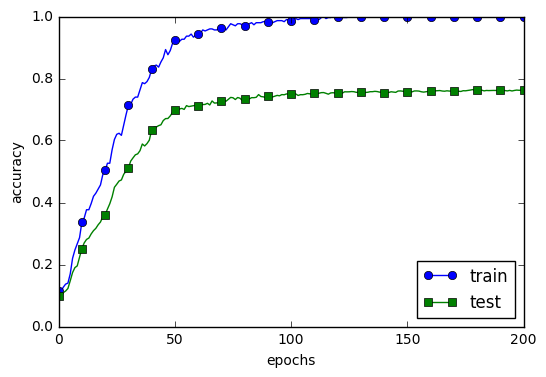

In [8]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
#weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

훈련 데이터에 대해서는 정확도가 100% 가까이 보이는 반면, 시험 데이터에 대해서는 70% 안되는 성능을 보인다. 즉, 훈련 데이터에 오버피팅이 되었다고 볼 수 있다.

6.4.2 가중치 감소

오버피팅을 막기 위해 가장 먼저 시행 되었던 것이 가중치 감소이다. 원래 오버피팅은 가중치가 큰 매개변수로 인해 발생하는 경우가 많아서, 가중치가 큰 값에는 그에 상응하는 패널티를 주어 오버피팅을 억제하는 방법을 사용했었다.

가중치가 큰 값이 크게 변하지 못하게 손실함수에 $\frac{\lambda}{2} \lVert \mathbf{W} \rVert_2$ 을 더해준다. 이 때 $\lambda$는 정규화 매개변수로서 이 값이 클 수록 큰 가중치에 큰 패널티를 부과한다고 생각할 수 있다.

[그림 6-21] 가중치 감소를 이용한 훈련데이터와 시험데이터의 정확도
![](data/images/fig%206-21.png)
여전히 오버피팅이 존재하지만 가중치 감소 사용하기 전 보다는 정확도의 차이가 많이 줄었다.

6.4.3 드롭 아웃

신경망이 좀 더 복잡해지면 가중치 감소로도 오버피팅을 줄이기가 힘들수 있다. 이럴 때 사용할 드롭 아웃이란 방법을 살펴보자.

드롭 아웃은 쉽게 말하면 훈련 중에 임의의 뉴런을 삭제하는 것이다. 하지만, 시험데이터에 대해서는 뉴런을 삭제 하지 않고 훈련 때 삭제한 뉴런의 출력에 삭제한 비율을 곱하여 출력한다.

[그림 6-22] 드롭아웃의 개념
![](data/images/fig%206-22.png)

In [8]:
#드롭 아웃 구현
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

드롭 아웃을 사용 했을 떄와 그렇지 않을 때와 비교해서 살펴보자.

(코드 이해는 추후에 다시..)

train loss:2.31884400434
=== epoch:1, train acc:0.116666666667, test acc:0.1004 ===
train loss:2.32928629395
train loss:2.31464320472
train loss:2.32895453412
=== epoch:2, train acc:0.12, test acc:0.0986 ===
train loss:2.33963346806
train loss:2.30874146477
train loss:2.30109652586
=== epoch:3, train acc:0.123333333333, test acc:0.1009 ===
train loss:2.31193838054
train loss:2.31396318841
train loss:2.31573082147
=== epoch:4, train acc:0.123333333333, test acc:0.1038 ===
train loss:2.30941668566
train loss:2.29910550929
train loss:2.27315224325
=== epoch:5, train acc:0.126666666667, test acc:0.1052 ===
train loss:2.29125985489
train loss:2.31247779957
train loss:2.30177453452
=== epoch:6, train acc:0.13, test acc:0.1071 ===
train loss:2.30767865497
train loss:2.28649131077
train loss:2.32215069282
=== epoch:7, train acc:0.123333333333, test acc:0.1099 ===
train loss:2.31360183766
train loss:2.29813101943
train loss:2.26877391376
=== epoch:8, train acc:0.126666666667, test acc:0.1121 ==

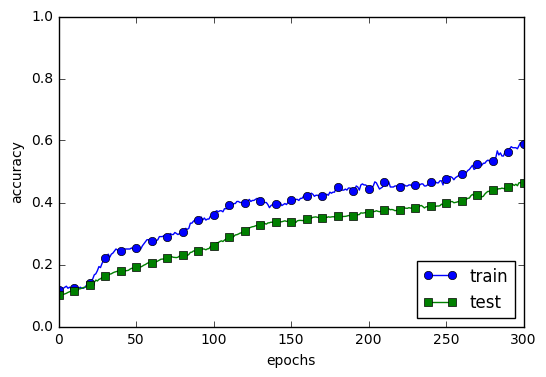

In [9]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


결과를 좀 더 깔끔한 그림으로 보면,

[그림 6-23] 드롭아웃을 적용한 경우와 그렇지 않은 경우 정확도 비교
![](data/images/fig%206-23.png)
이 결과로 드롭아웃을 통해 훈련 데이터에 오버피팅이 생기는것을 막아주는 것을 알 수 있다.

6.5 적절한 하이퍼파라미터 값 찾기.

주요 초모수(하이퍼파라미터) 값으로는 각 층의 뉴런 수, 배치의 크기, 매개변수 갱신 시의 학습률과 가중치 감소 등이 있다. 이러한 초모수 값들은 사람이 어떻게 설정해주느냐에 따라서 모델의 성능에 큰 영향을 준다. 이 초모수 값을 효율적으로 셋팅할 수 있는 방법을 알아보자.

6.5.1 검증 데이터

지금 까지 데이터를 훈련 데이터와 시험 데이터로 나누어서 모델을 학습 시켰다. 하지만, 초모수를 평가 할 때에는 시험 데이터를 사용 해서는 안된다.

그 이유는 초모수가 시험 데이터에 오버피팅 될 수 있기 때문이다. 즉, 초모수 값의 좋음을 시험 데이터로 확인 하게 되면 초모수 값이 시험 데이터에 적합하도록 조정이 될 수 있기 때문이다.

그래서 초모수를 검증하기 위한 데이터를 또 다시 구분한다. 그 데이터를 검증 데이터(validation data)라고 부른다.

정리를 하면,

훈련 데이터: 매개변수 학습

검증 데이터: 초모수 성능 평가

시험 데이터: 모델의 성능 평가

데이터 셋에 따라 처음부터 훈련, 검증, 시험 데이터로 나누어 주는 경우도 있지만, MNIST의 경우에는 시험과 훈련으로만 나누어져있기 때문에

우리가 직접 나누어 주어야 한다.

In [16]:
#훈련 데이터 중 20%를 검증 데이터로 하자
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist
from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist()

#훈련 데이터를 섞는다
x_train, t_train = shuffle_dataset(x_train, t_train)

#20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

6.5.2 하이퍼파라미터 최적화

대략의 아이디어는 이렇다. 어느 정도의 범위를 지정해준 다음에 그 범위 안의 임의로 초모수에 대해 정확도를 평가한 후 정확도를 살펴보면서 그 범위를 점점 줄여나가는 것이다. 

주로 0.001~1000과 같은 10의 거듭제곱으로 나타나는 단위로 범위를 지정한다. 이를 '로그 스케일'이라 함.

초모수 최적화에는 시간이 굉장히 많이 걸리므로 1회 평가에 걸리는 시간을 단축시키는 것이 좋다.

정리하면,

0단계: 초모수 값의 범위 설정

1단계: 설정된 범위에서 임의로 초모수 값 추출

2단계: 그 초모수에 대해 검증 데이터로 정확도 평가

3단계: 1,2,단계를 반복하여 정확도를 비교해서 적절하게 초모수 범위를 줄여나감.

6.5.3 하이퍼파라미터 최적화 구현

최적화에서의 학습률과 가중치 감소의 세기를 조절하는 계수에 대한 최적의 값을 찾아보도록 하자.

val acc:0.1 | lr:1.5108902957961246e-06, weight decay:5.757694781802799e-08
val acc:0.13 | lr:1.0272717891179226e-06, weight decay:1.238274662681549e-07
val acc:0.06 | lr:1.6389815426251182e-05, weight decay:1.5001564756176684e-07
val acc:0.15 | lr:0.0002870441393406857, weight decay:1.323767516564409e-06
val acc:0.09 | lr:0.00014795655261408508, weight decay:2.9022797876474452e-08
val acc:0.1 | lr:1.4621405911143722e-06, weight decay:1.5421449029904412e-05
val acc:0.6 | lr:0.0056833237903080504, weight decay:5.444448666351103e-07
val acc:0.09 | lr:2.0252652998809807e-06, weight decay:9.963852285476744e-08
val acc:0.14 | lr:1.0625265553252448e-06, weight decay:4.561080824242266e-06
val acc:0.06 | lr:2.5871532125248047e-05, weight decay:2.584435949460577e-07
val acc:0.08 | lr:2.051822475398186e-05, weight decay:3.004224066895585e-07
val acc:0.07 | lr:0.00020864519685324888, weight decay:7.614304403212685e-05
val acc:0.21 | lr:0.0011603877695343845, weight decay:7.731617614367808e-06
val

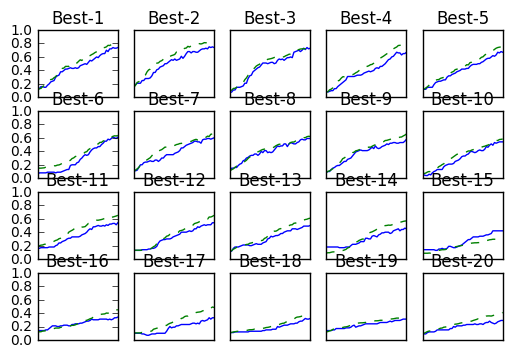

In [18]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()


[그림 6-24] 각각의 초모수에 대해 검증데이터와 훈련 데이터의 정확도
![](data/images/fig%206-24.png)
Best1~5까지가 가장 높은 정확도를 나타내었다. 각 경우의 초모수(학습률, 가중치 감소 계수)를 본 후에 조금씩 그 범위를 줄여 나가면 된다.

6.6 정리

이번 장에선 신경망 학습에 중요한 몇가지 기술을 정리해보자.

매개변수 갱신 방법:SGD, 모멘텀, AdaGrad, Adam 등

가중치 초깃값을 어떻게 설정 할것인가: Xavier 초깃값, He 초깃값

배치 정규화 : 학습 속도 개선, 오버피팅 방지

드롭 아웃 : 오버피팅 방지

초모수 최적화: 검증 데이터를 통한 범위 축소로 추정